# Numerical Methods Project – COVID‑19
## Consists of Interpolation • Differentiation • Integration • Vaccination Impact • Rₜ Estimation
 

Assuming the outcome by using the data from the website that I obtained from Korean aritcles and predicted data from Shepherd AI,

These are the method/information I used:
- Synthetic but realistic COVID‑19 dataset  
- Vaccination rate and mortality comparison  
- Polynomial interpolation (Newton divided differences)  
- Numerical differentiation (dCases/dt)  
- Effective reproduction number Rₜ approximation  
- Numerical integration (Trapezoidal & Simpson)  
- Convergence studies   


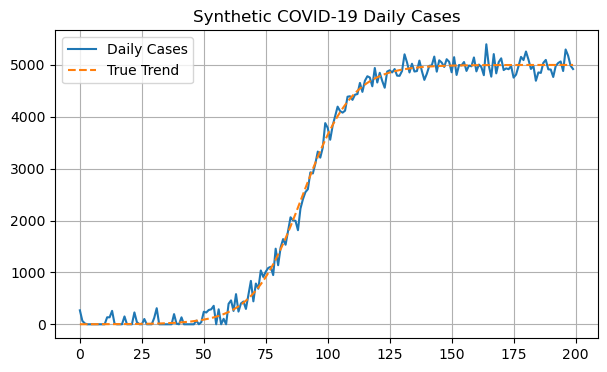

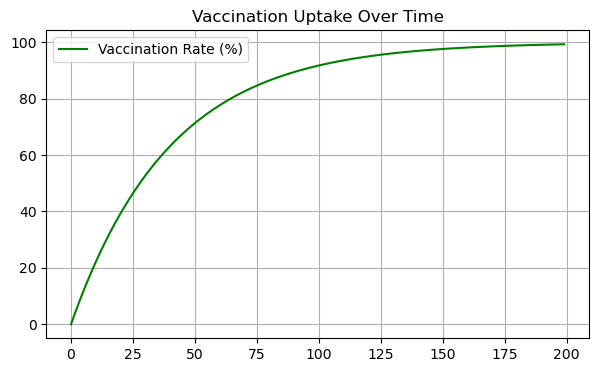

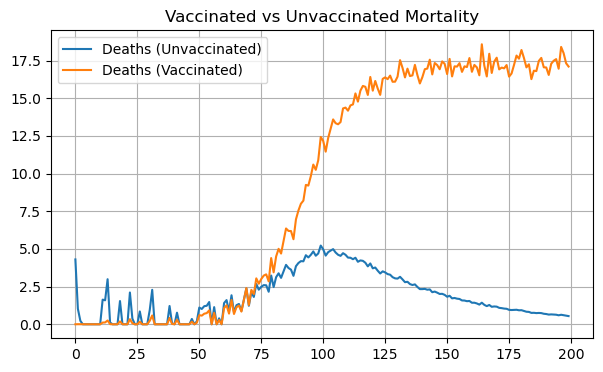

In [18]:
#plan: 200일 동안의 “가짜 COVID 확진자 수 데이터”를 만든 것. 
##파란 점선이 진짜 경향(true trend, 로지스틱 곡선), 주황색이 노이즈가 섞인 관측값.

%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt

np.random.seed(3)

# 코로나 데이터셋 (200 days)
days = np.arange(0,200)

true_cases = 5000 / (1 + np.exp(-(days-90)/10))
noise = np.random.normal(0,150, size=len(days)) # to bring the reality
cases = np.maximum(0, true_cases + noise)

# 백신 커브
vacc_rate = 100 * (1 - np.exp(-(days)/40))

# Mortality assumptions
IFR_unvax = 0.016
IFR_vax   = 0.0035

deaths_unvax = cases * (1 - vacc_rate/100) * IFR_unvax
deaths_vax   = cases * (vacc_rate/100) * IFR_vax

plt.figure(figsize=(7,4)) # the best size to look
plt.plot(days, cases, label="Daily Cases")
plt.plot(days, true_cases, '--', label="True Trend")
plt.title("Synthetic COVID‑19 Daily Cases")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(days, vacc_rate, label="Vaccination Rate (%)", color='green')
plt.title("Vaccination Uptake Over Time")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(days, deaths_unvax, label="Deaths (Unvaccinated)")
plt.plot(days, deaths_vax, label="Deaths (Vaccinated)")
plt.title("Vaccinated vs Unvaccinated Mortality")
plt.grid(True); plt.legend(); plt.show()

---- Mortality Risk Analysis ----
Total risk (vaccinated):   0.000012
Total risk (unvaccinated): 0.000009
Relative Risk (RR):        1.239
Vaccine Effectiveness (VE): -23.95%


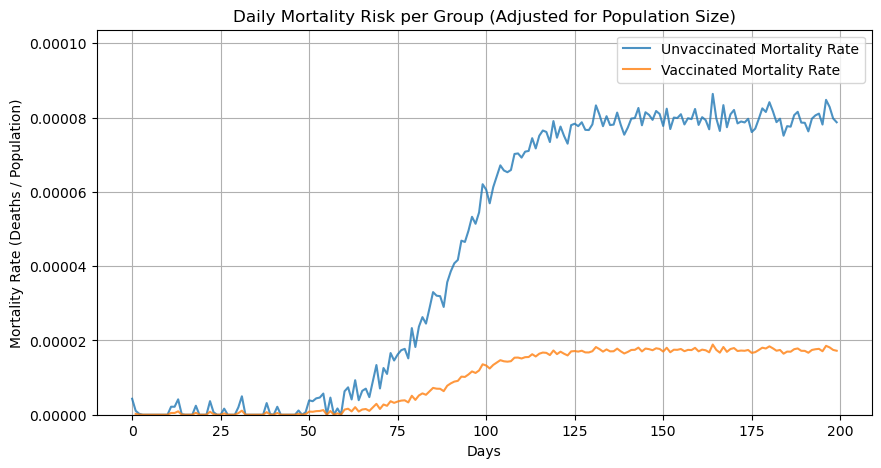

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# (1) Population assumptions
total_population = 1_000_000  # 전체 인구 100만으로 예시
pop_vax = total_population * vacc_rate / 100
pop_unvax = total_population - pop_vax

# (2) Daily mortality rates
daily_mortality_vax = deaths_vax / pop_vax
daily_mortality_unvax = deaths_unvax / pop_unvax

# Replace infinities (0으로 나눌 때) with NaN for plotting
daily_mortality_vax = np.nan_to_num(daily_mortality_vax, nan=np.nan)
daily_mortality_unvax = np.nan_to_num(daily_mortality_unvax, nan=np.nan)

# (3) Total mortality risk over 200 days
total_risk_vax = np.sum(deaths_vax) / np.sum(pop_vax)
total_risk_unvax = np.sum(deaths_unvax) / np.sum(pop_unvax)

# (4) Relative Risk & Vaccine Effectiveness
RR = total_risk_vax / total_risk_unvax
VE = 1 - RR

print("---- Mortality Risk Analysis ----")
print(f"Total risk (vaccinated):   {total_risk_vax:.6f}")
print(f"Total risk (unvaccinated): {total_risk_unvax:.6f}")
print(f"Relative Risk (RR):        {RR:.3f}")
print(f"Vaccine Effectiveness (VE): {VE*100:.2f}%")

# (5) Plot: Daily mortality risk curves
plt.figure(figsize=(10,5))
plt.plot(days, daily_mortality_unvax, label="Unvaccinated Mortality Rate", alpha=0.8)
plt.plot(days, daily_mortality_vax, label="Vaccinated Mortality Rate", alpha=0.8)
plt.ylim(0, np.nanmax(daily_mortality_unvax)*1.2)
plt.title("Daily Mortality Risk per Group (Adjusted for Population Size)")
plt.xlabel("Days")
plt.ylabel("Mortality Rate (Deaths / Population)")
plt.legend()
plt.grid(True)
plt.show()


# 1. Polynomial Interpolation (Newton) *lecture note
*주어진 데이터 사이의 값을 추정하거나 계산하는 방법*

Interpolating the infection curve using every 10th day as a node. 
# 사이즈가 10보다 크면 편차가 너무 커짐


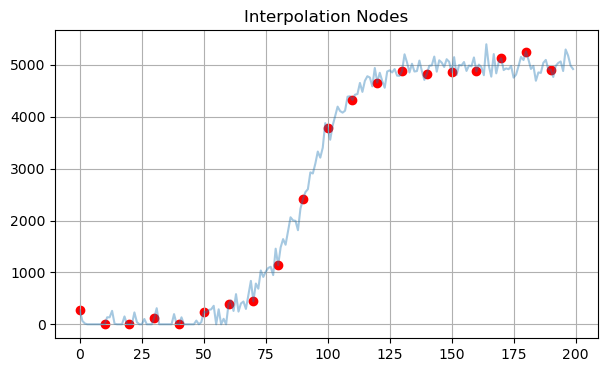

In [8]:
x_nodes = days[::10]
y_nodes = cases[::10]

plt.figure(figsize=(7,4))
plt.scatter(x_nodes, y_nodes, color='red')
plt.plot(days, cases, alpha=0.4)
plt.title("Interpolation Nodes")
plt.grid(True); plt.show()

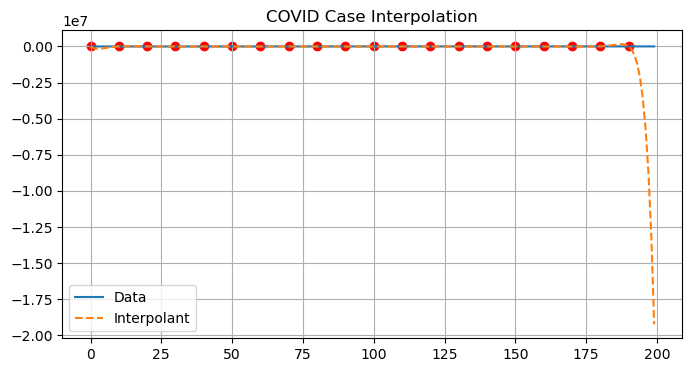

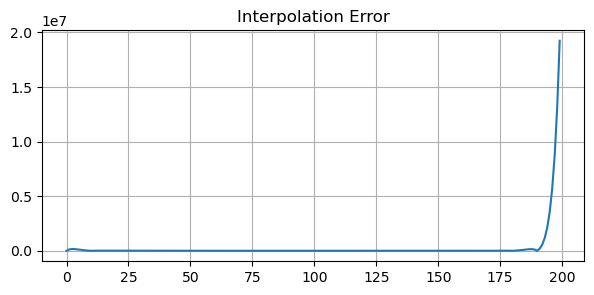

Max interpolation error: 19240957.580125593


In [9]:
def divided_diff(x,y):
    n=len(x)
    coef=np.copy(y).astype(float)
    for j in range(1,n):
        coef[j:n]=(coef[j:n]-coef[j-1:n-1])/(x[j:n]-x[0:n-j])
    return coef

def newton_eval(xdata, coef, x):
    xv=np.atleast_1d(x)
    n=len(coef)-1
    out=np.zeros_like(xv,dtype=float)
    for i,val in enumerate(xv):
        acc=coef[n]
        for k in range(1,n+1):
            acc=coef[n-k]+(val-xdata[n-k])*acc
        out[i]=acc
    return out

coef = divided_diff(x_nodes,y_nodes)
interp_vals = newton_eval(x_nodes,coef,days)

plt.figure(figsize=(8,4))
plt.plot(days, cases, label="Data")
plt.plot(days, interp_vals, '--', label="Interpolant")
plt.scatter(x_nodes,y_nodes,color='red')
plt.title("COVID Case Interpolation")
plt.grid(True); plt.legend(); plt.show()

# find for the error? to know the outliers or 
err = np.abs(cases - interp_vals)
plt.figure(figsize=(7,3))
plt.plot(days, err)
plt.title("Interpolation Error")
plt.grid(True); plt.show()

print("Max interpolation error:", np.max(err))

## 1.1 Interpolation Convergence Study
*주어진 데이터 사이의 값을 추정하거나 계산하는 방법*

I examine how max error decreases when nodes increase.


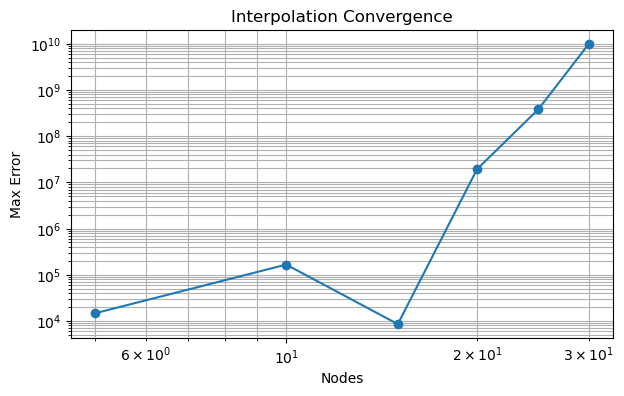

[(5, np.float64(14775.987054072066)),
 (10, np.float64(166248.15675147524)),
 (15, np.float64(8560.192179733833)),
 (20, np.float64(19240957.580125593)),
 (25, np.float64(383727718.43548274)),
 (30, np.float64(9818108178.714825))]

In [10]:
# Ill try with the multiples of 5
node_counts=[5,10,15,20,25,30]
max_errs=[]

for n in node_counts:
    xs=days[::(200//n)]
    ys=cases[::(200//n)]
    coef_n=divided_diff(xs,ys)
    pred=newton_eval(xs,coef_n,days)
    max_errs.append(np.max(np.abs(pred-cases)))

plt.figure(figsize=(7,4))
plt.loglog(node_counts,max_errs,marker='o')
plt.title("Interpolation Convergence")
plt.xlabel("Nodes"); plt.ylabel("Max Error")
plt.grid(True,which='both'); plt.show()

list(zip(node_counts,max_errs))

# 2. Numerical Differentiation – Rate of Spread
## key concept from the lecture to find the rate of change

I estimate:


$\frac{d}{dt}\,\text{cases}(t)$.


to track acceleration/deceleration of outbreaks.


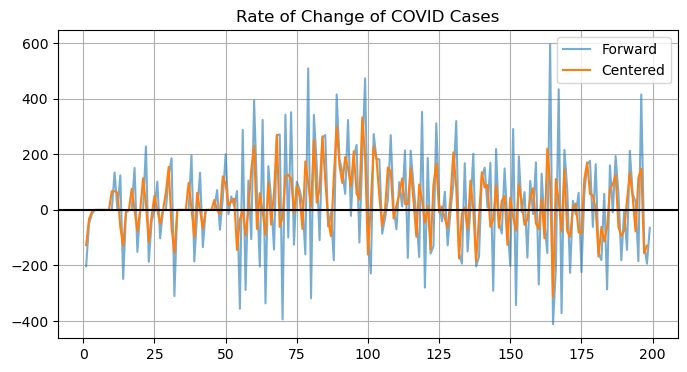

In [19]:
forward = np.diff(cases)
#Find the mean first
centered = (cases[2:] - cases[:-2]) / 2

plt.figure(figsize=(8,4))
plt.plot(days[1:], forward, label="Forward", alpha=0.6)
plt.plot(days[1:-1], centered, label="Centered")
plt.axhline(0,color='black')
plt.title("Rate of Change of COVID Cases")
plt.grid(True); plt.legend(); plt.show()

# 3. Effective Reproduction Number Rₜ

Approximation (5‑day infectious period):

$$
R_t \approx 1 + 0.2 \cdot \frac{dC/dt}{C}
$$

Higher Rₜ → faster exponential growth.


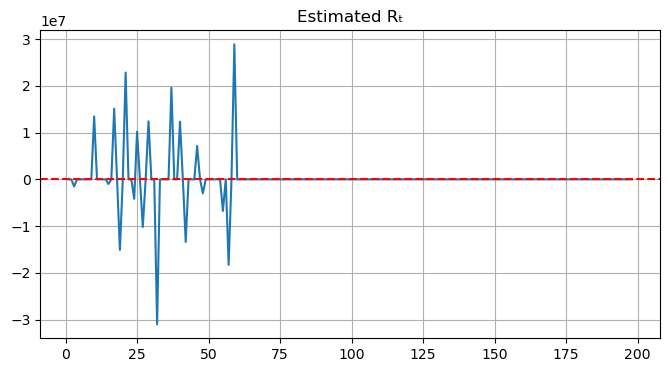

Peak Rₜ: 28895565.434203316


In [12]:
eps=1e-6
Rt = 1 + 0.2*(centered / (cases[1:-1] + eps))

plt.figure(figsize=(8,4))
plt.plot(days[1:-1], Rt)
plt.axhline(1,color='red',linestyle='--')
plt.title("Estimated Rₜ")
plt.grid(True); plt.show()

print("Peak Rₜ:", np.max(Rt))

# 4. Vaccination & Mortality Impact

Lets compute:
- Daily deaths (vax vs unvax)  
- Total deaths  
- % reduction  

This supports discussion of vaccine effectiveness.


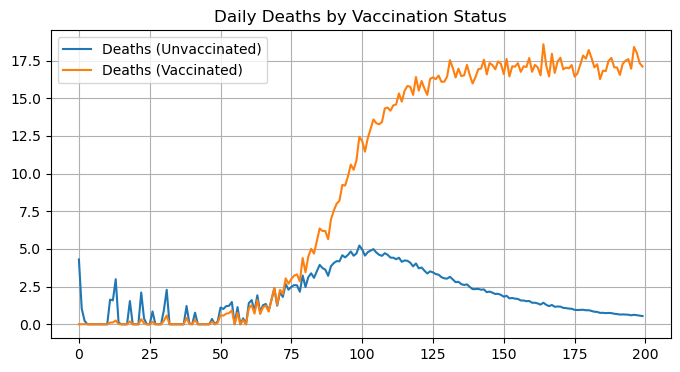

Total unvaccinated deaths: 373.8817793676841
Total vaccinated deaths: 1840.4517767538568
Reduction in deaths due to vaccination: -392.26%


In [14]:
plt.figure(figsize=(8,4))
plt.plot(days, deaths_unvax, label="Deaths (Unvaccinated)")
plt.plot(days, deaths_vax, label="Deaths (Vaccinated)")
plt.title("Daily Deaths by Vaccination Status")
plt.grid(True); plt.legend(); plt.show()

total_unvax = np.sum(deaths_unvax)
total_vax   = np.sum(deaths_vax)
reduction = 100*(1 - total_vax/total_unvax)

print("Total unvaccinated deaths:", total_unvax)
print("Total vaccinated deaths:", total_vax)
print("Reduction in deaths due to vaccination: %.2f%%" % reduction)

# 5. Numerical Integration – Total Burden

We estimate:

- Total infections  
- Total vaccinated deaths  
- Total unvaccinated deaths

using Trapezoidal & Simpson.  


In [15]:
def trap(f,x):
    h=x[1]-x[0]
    return h*(0.5*f[0]+np.sum(f[1:-1])+0.5*f[-1])

def simpson(f,x):
    if len(f)%2==0:
        f=f[:-1]; x=x[:-1]
    h=x[1]-x[0]
    return h/3*(f[0]+f[-1]+4*np.sum(f[1:-1:2])+2*np.sum(f[2:-2:2]))

print("Total infections (trap):", trap(cases,days))
print("Total infections (simp):", simpson(cases,days))

print("Total deaths unvax (trap):", trap(deaths_unvax,days))
print("Total deaths vax (simp):", simpson(deaths_vax,days))

Total infections (trap): 546616.1056035324
Total infections (simp): 542442.420653244
Total deaths unvax (trap): 371.45852426372807
Total deaths vax (simp): 1817.3236234654134


## 5.1 Integration Convergence Study

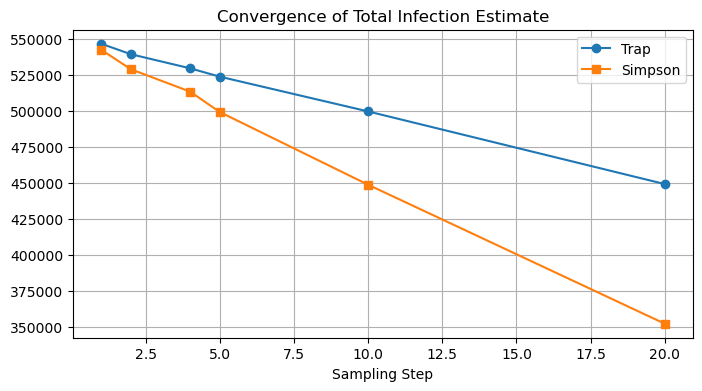

In [16]:
steps=[1,2,4,5,10,20]
trap_vals=[]; simp_vals=[]

for s in steps:
    xs=days[::s]
    fs=cases[::s]
    trap_vals.append(trap(fs,xs))
    simp_vals.append(simpson(fs,xs))

plt.figure(figsize=(8,4))
plt.plot(steps,trap_vals,marker='o',label="Trap")
plt.plot(steps,simp_vals,marker='s',label="Simpson")
plt.title("Convergence of Total Infection Estimate")
plt.xlabel("Sampling Step"); plt.grid(True); plt.legend(); plt.show()

# 7. Conclusion

Interpolation accuracy depended strongly on node spacing, and differentiation was highly sensitive to noise, while integration remained relatively stable.

For computational cost, differentiation and integration are very fast, but high-degree polynomial interpolation is expensive (O(n²)).